# Quantum Channel for the Ancilla Density Matrix in Random Unitary Circuit

![](RUC.png)

We are going to evaluate the effect of the matrices along the diagonal slice on the ancilla density matrix. After summing over the indices $(s_1,s_2)$ for a neighbouring pair of sites we lose the final layer by unitarity, and we are left with:

![](MPO.png)

The input ancilla density matrix $\rho_{a_1a_2a_3,\bar a_1\bar a_2 \bar a_3}$ will be contracted in at the bottom, and the indices of the output matrix $\rho'_{b_1b_2b_3,\bar b_1\bar b_2 \bar b_3}$ will pop out of the top. The task is to evaluate $\rho'$ for a given assignment of indices $b_j$ if all components of $\rho$ are known.

The first thing to notice is that the final index is traced over, lowering the dimension of the density matrix before we start. We then work from the [middle out](https://www.youtube.com/watch?v=0rhdOt9bOHE), contracting in a $U$ and $\bar U$ at each step. This is an $O(N^2)$ operation, where $N=q^d$ for depth $d$.

In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

In [2]:
from ruc_einsum import ruc_channel, tensor_trace, trace_square, matrix_to_tensor, tensor_to_matrix, random_ρ

## Complexity

In [3]:
timeit_results = []
q = 2
depths =  np.arange(5,13)
for d in depths:
    res = %timeit -o ruc_channel(random_ρ(q, d))
    timeit_results.append(res.average)

1.06 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.5 ms ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.11 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
29.6 ms ± 915 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
114 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
455 ms ± 5.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.83 s ± 30.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.06 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check the $4^d$ scaling

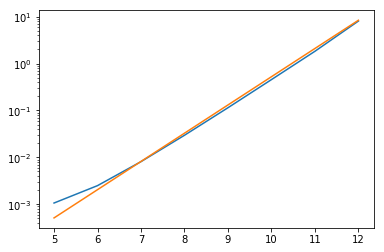

In [4]:
plt.semilogy(depths, timeit_results, depths, 0.0000005*4**depths)

## Purity

In [79]:
q = 2
depth = 10
# ρ = np.zeros(2*depth*[q])
# ρ[tuple(2*depth*[0])] = 1
ρ = random_ρ(q, depth)
purity_trace = np.array([])
eigenvalues = np.array([])

for step in range(10000):
    purity_trace = np.append(purity_trace, trace_square(ρ))
    if step % 10 == 0:
        print("step ", step)
        eigenvalues = np.concatenate([eigenvalues, eigh(tensor_to_matrix(ρ), eigvals_only=True)])
    ρ = ruc_channel(ρ)

step  0
step  10
step  20
step  30
step  40
step  50
step  60
step  70
step  80
step  90
step  100
step  110
step  120
step  130
step  140
step  150
step  160
step  170
step  180
step  190
step  200
step  210
step  220
step  230
step  240
step  250
step  260
step  270
step  280
step  290
step  300
step  310
step  320
step  330
step  340
step  350
step  360
step  370
step  380
step  390
step  400
step  410
step  420
step  430
step  440
step  450
step  460
step  470
step  480
step  490
step  500
step  510
step  520
step  530
step  540
step  550
step  560
step  570
step  580
step  590
step  600
step  610
step  620
step  630
step  640
step  650
step  660
step  670
step  680
step  690
step  700
step  710
step  720
step  730
step  740
step  750
step  760
step  770
step  780
step  790
step  800
step  810
step  820
step  830
step  840
step  850
step  860
step  870
step  880
step  890
step  900
step  910
step  920
step  930
step  940
step  950
step  960
step  970
step  980
step  990
step  1000


KeyboardInterrupt: 

In [90]:
np.mean(purity_trace)

(0.19758590086368757-2.5727759165070967e-18j)

In [103]:
-np.log((4/5)**11)

2.454579064456307

Text(0, 0.5, 'Second Renyi Entropy')

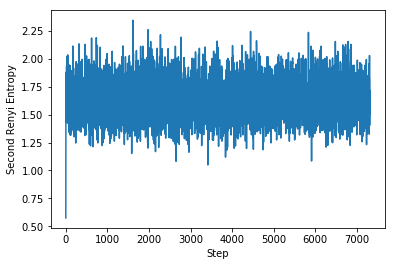

In [80]:
plt.plot(-np.log(purity_trace))
plt.xlabel("Step")
plt.ylabel("Second Renyi Entropy")

## Spectrum

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9000e+01,
        1.0300e+02, 8.2000e+01, 3.4000e+01, 7.5000e+01, 1.2500e+02,
        3.4900e+02, 4.3300e+02, 4.4300e+02, 4.9000e+02, 3.4500e+02,
        3.1000e+02, 5.3400e+02, 7.1700e+02, 9.9200e+02, 1.0500e+03,
        1.3840e+03, 1.7060e+03, 1.8800e+03, 2.9170e+03, 3.5430e+03,
        3.9230e+03, 4.9280e+03, 5.7800e+03, 6.6130e+03, 8.5720e+03,
        9.7160e+03, 1.1749e+04, 1.4218e+04, 1.6423e+04, 1.7744e+04,
        1.8625e+04, 2.0787e+04, 2.3455e+04, 2.3796e+04, 2.6016e+04,
        2.4759e+04, 2.2702e+04, 2.1872e+04, 2.1128e+04, 2.0033e+04,
        1.5928e+04, 1.5911e+04, 1.7785e+04, 1.9795e+04, 2.5387e+04,
        3.0097e+04, 3.4455e+04, 3.2161e+04, 2.1283e+04, 1.9553e+04,
        4.0526e+04, 4.8833e+04, 4.8951e+04, 2.94

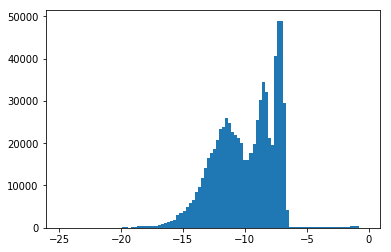

In [84]:
plt.hist(np.log(eigenvalues), bins=100)

Compare with fully random density matrix

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   2.,   1.,   2.,   2.,   4.,   3.,   5.,   4.,   8.,   9.,
         11.,  15.,  19.,  24.,  30.,  37.,  48.,  62.,  76.,  95., 118.,
        138., 156., 137.,  14.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-24.39240909, -23.91030403, -23.42819898, -22.94609393,
        -22.46398888, -21.98188383, -21.49977878, -21.01767373,
        -20.53556868, -20.05346363, -19.57135858, -19.08925353,
        -18.60714848, -18.12504343, -17.64293838, -17.16083332,
        -16.67872827, -16.19662322, -15.71451817, -15.23241312,
        -14.75030807, -14.26820302, -13.78609797, -13.30399292,
        -12.82188787, -12.33978282, -11.85767777, -11.37557272,
        -10.89346767, -10.41136262,  -9.92925756,  -9.44715251,
         -8.96504746,  -8.48294241,  -8.00083736,  -7.51873231,
         -7.03662726,  -6.55452221,  -6.07241716,  -5.59031211,
         -5.108207

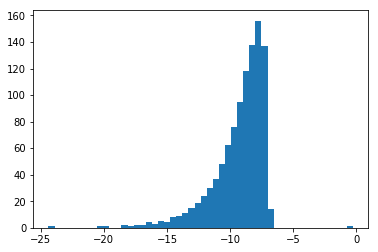

In [89]:
plt.hist(np.log(eigh(tensor_to_matrix(random_ρ(2, 10)), eigvals_only=True)), bins=50)